In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib . pyplot as plt # plots
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
crs = 'epsg:4326'
from sklearn import metrics
import warnings

warnings.filterwarnings('ignore')

## Train and Test sets

In [2]:
county_data = pd.read_csv('speed_by_county.csv')

In [3]:
county_data.head()

,Unnamed: 0,GEOID,geometry,NAME,STATEFP,NAMELSAD,avg_d_mbps_wt,tests,group,group_num
0,2613,19091,POLYGON ((-109438.9194760559 4758042.766279818...,Humboldt,19,Humboldt County,45.418447,331.0,0 to 50 Mbps,1.0
1,2316,5061,POLYGON ((-154686.5686538647 3801321.932758778...,Howard,5,Howard County,20.297851,296.0,0 to 50 Mbps,1.0
2,2185,35031,POLYGON ((-1510665.005927161 4178550.859380335...,McKinley,35,McKinley County,23.891873,1855.0,0 to 50 Mbps,1.0
3,142,45023,"POLYGON ((1043390.474378094 3869291.109520722,...",Chester,45,Chester County,41.450062,1350.0,0 to 50 Mbps,1.0
4,331,28009,"POLYGON ((289775.6275383779 3858200.252850609,...",Benton,28,Benton County,43.997322,233.0,0 to 50 Mbps,1.0


In [4]:
#Dataframe census data
import censusdata

# Useful for finding the ACS tables you want 
# censusdata.search('acs5', 2018, 'label', 'broadband') 
# censusdata.printtable(censusdata.censustable('acs5', 2018, 'B28011'))

# Pull ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B01002_001E': 'Median Age',
    'B06009_001E': 'Education Total',
    'B06009_003E': 'High School graduate',
    'B25107_001E': 'Median Home Value', #Median Value by year built
    'B28003_002E': 'Households with computer',
    'B28001_005E': 'Households with smartphone',
    #'B25109_001E': 'Median Value by year moved',
    #'B25097_001E': 'Median Value by morgage',
    
    
    }

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "*"), 
                                                    ("county", "*"),]), list(census_tables.keys()))
acs_df["GEOID"] = acs_df["GEO_ID"].map(lambda x: str(x)[-5:])
acs_df = acs_df.drop(columns='GEO_ID')
acs_df = acs_df.rename(columns=census_tables)
acs_df.head()

,Race Total,White,Black,Median Income,Median Age,Education Total,High School graduate,Median Home Value,Households with computer,Households with smartphone,GEOID
"Washington County, Mississippi: Summary level: 050, state:28> county:151",47086,12097,33982,30834.0,36.9,30308.0,9254.0,74700,13858,11819,28151
"Perry County, Mississippi: Summary level: 050, state:28> county:111",12028,9475,2368,39007.0,40.9,8198.0,3290.0,83700,3552,3081,28111
"Choctaw County, Mississippi: Summary level: 050, state:28> county:019",8321,5631,2596,37203.0,44.0,5799.0,2201.0,81600,2345,1894,28019
"Itawamba County, Mississippi: Summary level: 050, state:28> county:057",23480,21346,1681,40510.0,40.0,15684.0,4743.0,89500,7103,6228,28057
"Carroll County, Mississippi: Summary level: 050, state:28> county:015",10129,6523,3503,43060.0,47.0,7248.0,2422.0,89300,2813,2413,28015


In [5]:
acs_df = acs_df.astype({'GEOID': 'int64'})

In [6]:
county_data = county_data.drop(columns=['geometry'])

In [7]:
merged_gdf = (gpd.GeoDataFrame(county_data.merge(acs_df, on="GEOID", how="left"), crs=crs))
merged_gdf.head(5)

,Unnamed: 0,GEOID,NAME,STATEFP,NAMELSAD,avg_d_mbps_wt,tests,group,group_num,Race Total,White,Black,Median Income,Median Age,Education Total,High School graduate,Median Home Value,Households with computer,Households with smartphone
0,2613,19091,Humboldt,19,Humboldt County,45.418447,331.0,0 to 50 Mbps,1.0,9566,9315,25,52219.0,43.0,6682.0,2401.0,102300,3481,2832
1,2316,5061,Howard,5,Howard County,20.297851,296.0,0 to 50 Mbps,1.0,13389,8964,2761,35900.0,38.8,8868.0,3312.0,92500,3990,3452
2,2185,35031,McKinley,35,McKinley County,23.891873,1855.0,0 to 50 Mbps,1.0,72849,10948,488,31674.0,32.0,43920.0,14797.0,64500,12016,9720
3,142,45023,Chester,45,Chester County,41.450062,1350.0,0 to 50 Mbps,1.0,32326,19601,11938,40080.0,41.5,22302.0,9199.0,90500,9259,7264
4,331,28009,Benton,28,Benton County,43.997322,233.0,0 to 50 Mbps,1.0,8253,5058,2956,35974.0,40.4,5775.0,1959.0,68800,2371,1923


In [8]:
merged_gdf['% White'] = merged_gdf['White'] / merged_gdf['Race Total'] * 100
merged_gdf['% Black'] = merged_gdf['Black'] / merged_gdf['Race Total'] * 100
merged_gdf['% High School'] = merged_gdf['High School graduate'] / merged_gdf['Education Total'] * 100
cols = ['GEOID', 'NAME', '% White', '% Black', 'Median Income', 'Median Age', 
        '% High School', 'Median Home Value','Households with computer', 'Households with smartphone', 'tests', 'group', 'group_num', 'avg_d_mbps_wt']
ml_data = merged_gdf[cols]
ml_data.head()

,GEOID,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,Households with computer,Households with smartphone,tests,group,group_num,avg_d_mbps_wt
0,19091,Humboldt,97.376124,0.261342,52219.0,43.0,35.932356,102300,3481,2832,331.0,0 to 50 Mbps,1.0,45.418447
1,5061,Howard,66.950482,20.621406,35900.0,38.8,37.347767,92500,3990,3452,296.0,0 to 50 Mbps,1.0,20.297851
2,35031,McKinley,15.028346,0.669879,31674.0,32.0,33.690801,64500,12016,9720,1855.0,0 to 50 Mbps,1.0,23.891873
3,45023,Chester,60.635402,36.930025,40080.0,41.5,41.247422,90500,9259,7264,1350.0,0 to 50 Mbps,1.0,41.450062
4,28009,Benton,61.286805,35.817279,35974.0,40.4,33.922078,68800,2371,1923,233.0,0 to 50 Mbps,1.0,43.997322


In [9]:
ml_data.loc[ml_data['Median Home Value'] < 0, 'Median Home Value'] = ml_data['Median Home Value'].median()

In [10]:
train_data = ml_data[ml_data.group_num.notna()]
test_data = ml_data[ml_data.group_num.isna()]

In [11]:
train_data.groupby('group_num')['Households with smartphone'].describe().T

group_num,1.0,2.0,3.0
count,853.000000,1143.000000,1.015000e+03
mean,3470.946073,11471.588801,7.306318e+04
std,2950.547343,18433.968801,1.513792e+05
min,27.000000,156.000000,4.430000e+02
25%,1463.000000,3842.000000,1.029700e+04
50%,2622.000000,7068.000000,2.774700e+04
75%,4471.000000,12803.500000,7.271750e+04
max,22460.000000,406797.000000,2.651467e+06


In [12]:
median_income = train_data['Median Income'].median()
train_data['Median Income'] = train_data['Median Income'].fillna(value=median_income)

In [13]:
train_data.groupby('group_num').count()

,GEOID,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,Households with computer,Households with smartphone,tests,group,avg_d_mbps_wt
group_num,,,,,,,,,,,,,
1.0,853,853,853,853,853,853,853,853,853,853,853,853,853
2.0,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143
3.0,1015,1015,1015,1015,1015,1015,1015,1015,1015,1015,1015,1015,1015


In [14]:
train_data1 = train_data[train_data['group_num']== 1]
train_data2 = train_data[train_data['group_num']== 2]
train_data3 = train_data[train_data['group_num']== 3]
#train_data4 = train_data[train_data['group_num2']== 4]
#train_data5 = train_data[train_data['group_num2']== 5]

In [15]:
from sklearn.utils import resample
df_minority_upsampled1 = resample(train_data1, 
                                 replace=True,     # sample with replacement
                                 n_samples=1143,  # to match majority class
                                 random_state=123) # reproducible results

df_minority_upsampled3 = resample(train_data3, 
                                 replace=True,     # sample with replacement
                                 n_samples=1143,  # to match majority class
                                 random_state=123) # reproducible results


train_data2 = pd.concat([df_minority_upsampled1, train_data2, df_minority_upsampled3])

In [17]:
train_data2.groupby('group_num').count()

,GEOID,NAME,% White,% Black,Median Income,Median Age,% High School,Median Home Value,Households with computer,Households with smartphone,tests,group,avg_d_mbps_wt
group_num,,,,,,,,,,,,,
1.0,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143
2.0,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143
3.0,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143,1143


In [18]:
features = ['% White', '% Black','Median Income', 'Median Age', '% High School', 'Median Home Value', 'Households with computer', 'Households with smartphone']
label = ['group_num']

x_train = train_data.loc[:,features]
y_train = train_data.loc[:,label].round()
x_test = test_data.loc[:,features]
y_test = test_data.loc[:,label].round()
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [23]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 9))}]

#Custom Function for accuracy
def custom_acc(y_train, y_pred):
    y_pred = y_pred.round()
    diff = (y_pred == y_train).sum()
    return diff/len(y_train)

acc = make_scorer(custom_acc)

## Lineal Model

In [32]:
# Lineal Model
lm = LinearRegression(normalize=True)
lm.fit(x_train, y_train)
rfe = RFE(lm)  

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= acc, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
results = model_cv.fit(x_train, y_train)
ls_results = pd.DataFrame(results.cv_results_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished


In [33]:
ls_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_features_to_select', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [34]:
ls_results.filter(['param_n_features_to_select','mean_test_score', 'rank_test_score', 'mean_train_score'])

,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,2,0.426775,6,0.425514
1,3,0.427105,5,0.427027
2,4,0.421454,7,0.421270
3,5,0.443710,4,0.442489
4,6,0.450353,3,0.449279
5,7,0.484893,1,0.485996
6,8,0.481568,2,0.482306


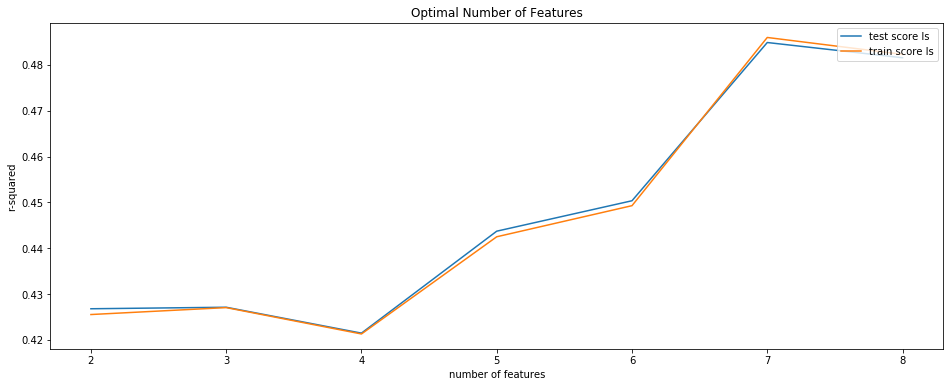

In [35]:
plt.figure(figsize=(16,6))
plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_test_score"])
plt.plot(ls_results["param_n_features_to_select"], ls_results["mean_train_score"])
plt.xlabel('number of features')
#plt.ylim(0,1)
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score ls', 'train score ls'], loc='upper right')

In [36]:
# final best model least squares
n_features_optimal = 7

lm = LinearRegression()
lm.fit(x_train, y_train)


rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

# predict prices of X_test
y_pred_ls = (rfe.predict(x_test)).round()
y_pred_ls_t = (rfe.predict(x_train)).round()

[ True  True  True  True  True False  True  True]
[1 1 1 1 1 2 1 1]


In [37]:
y_train

array([1., 1., 1., ..., 3., 3., 3.])

In [38]:
df1 = pd.DataFrame(y_pred_ls_t)
df1['real'] = y_train
df1['correct'] = df1[0] == df1['real']
df1.groupby('correct').count()

,0,real
correct,,
False,1551,1551
True,1460,1460


## Ridge Model
Penalization parameters = 10^1, 10^5, 10^10

In [39]:
#---------RIDGE----------------

# specify range of hyperparameters
alpha = [10**1, 10**5, 10**10]

df_rd = pd.DataFrame(columns = ['alpha', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in alpha:
    # specify model
    rd = Ridge(alpha=i, normalize=False)
    rd.fit(x_train, y_train)
    rfe_rd = RFE(rd)  

    # set up GridSearchCV()
    model_rd = GridSearchCV(estimator = rfe_rd, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_rd = model_rd.fit(x_train, y_train)
    rd_results = pd.DataFrame(results_rd.cv_results_)
    for index, row in rd_results.iterrows():
        df_rd = df_rd.append({'alpha' : i, 'features' : rd_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : rd_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':rd_results.loc[index, 'rank_test_score'],
                             'mean_train_score':rd_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_rd

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished


,alpha,features,mean_test_score,rank_test_score,mean_train_score
0,1.000000e+01,2.0,0.426775,6.0,0.425514
1,1.000000e+01,3.0,0.427105,5.0,0.426990
2,1.000000e+01,4.0,0.421454,7.0,0.421270
3,1.000000e+01,5.0,0.443710,4.0,0.442489
4,1.000000e+01,6.0,0.450353,3.0,0.449279
5,1.000000e+01,7.0,0.484893,1.0,0.486033
6,1.000000e+01,8.0,0.481568,2.0,0.482306
7,1.000000e+05,2.0,0.381605,7.0,0.382413
8,1.000000e+05,3.0,0.383931,5.0,0.384553
9,1.000000e+05,4.0,0.383931,5.0,0.384553


#### Best Ridge Model
- Features = 4
- Penalization = 10^5

In [40]:
# final model Ridge
n_features_optimal = 7

rd = Ridge(alpha=(10**1), normalize=False)
rd.fit(x_train, y_train)
rfe_rd = RFE(rd, n_features_to_select=n_features_optimal)  
          
rfe_rd = rfe_rd.fit(x_train, y_train)
print(rfe_rd.support_)
print(rfe_rd.ranking_)

# predict prices of X_test
y_pred_rd = (rfe.predict(x_test)).round()

[ True  True  True  True  True False  True  True]
[1 1 1 1 1 2 1 1]


In [41]:
y_pred_rd

array([2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 1., 1., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2.,
       2., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 1., 2.,
       1., 2., 2., 1., 2., 1., 1., 2., 2., 2., 2., 1.])

## Logistic Regression
Penalization Parameters = 0.01, 0.1, 1, 10, 100

In [42]:
#--------------------Logistic Regression-----------------------------
from sklearn.linear_model import LogisticRegression
# specify range of hyperparameters
C = [0.01, 0.1,1,10,100]

df_clf = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

# specify model
for i in C:
    clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=i, class_weight='balanced', multi_class='multinomial')
    clf.fit(x_train, y_train)
    rfe_clf = RFE(clf)  

    # set up GridSearchCV()
    model_clf = GridSearchCV(estimator = rfe_clf, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_clf = model_clf.fit(x_train, y_train)
    clf_results = pd.DataFrame(results_clf.cv_results_)
    for index, row in clf_results.iterrows():
        df_clf = df_clf.append({'C' : i, 'features' : clf_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : clf_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':clf_results.loc[index, 'rank_test_score'],
                             'mean_train_score':clf_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_clf

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.5min finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.4min finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.6min finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.6min finished


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.4min finished


,C,features,mean_test_score,rank_test_score,mean_train_score
0,0.01,2.0,0.463968,7.0,0.463855
1,0.01,3.0,0.499827,6.0,0.504225
2,0.01,4.0,0.506142,5.0,0.507214
3,0.01,5.0,0.610418,4.0,0.611646
4,0.01,6.0,0.611079,3.0,0.616775
5,0.01,7.0,0.619386,2.0,0.622274
6,0.01,8.0,0.624037,1.0,0.623418
7,0.10,2.0,0.463968,7.0,0.464113
8,0.10,3.0,0.498832,6.0,0.504004
9,0.10,4.0,0.507803,5.0,0.507362


In [43]:
df_clf

,C,features,mean_test_score,rank_test_score,mean_train_score
0,0.01,2.0,0.463968,7.0,0.463855
1,0.01,3.0,0.499827,6.0,0.504225
2,0.01,4.0,0.506142,5.0,0.507214
3,0.01,5.0,0.610418,4.0,0.611646
4,0.01,6.0,0.611079,3.0,0.616775
5,0.01,7.0,0.619386,2.0,0.622274
6,0.01,8.0,0.624037,1.0,0.623418
7,0.10,2.0,0.463968,7.0,0.464113
8,0.10,3.0,0.498832,6.0,0.504004
9,0.10,4.0,0.507803,5.0,0.507362


#### Best Logistic Model
- Features = 4
- Penalization = 1

In [44]:
# final model Logistic
n_features_optimal = 8

clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', C=0.10, class_weight='balanced', multi_class='multinomial')
clf.fit(x_train, y_train)
rfe_clf = RFE(clf, n_features_to_select=n_features_optimal)
          
model_clf = GridSearchCV(estimator = rfe_clf, 
                param_grid = hyper_params, 
                scoring= acc, 
                cv = folds, 
                verbose = 1,
                return_train_score=True)     
results_clf = model_clf.fit(x_train, y_train)
clf_results = pd.DataFrame(results_clf.cv_results_)

# predict prices of X_test
y_pred_clf = (results_clf.predict(x_test)).round()
y_pred_clf_r = (results_clf.predict(x_train)).round()

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.8min finished


In [45]:
clf_results.filter(['param_n_features_to_select','mean_test_score', 'rank_test_score', 'mean_train_score'])

,param_n_features_to_select,mean_test_score,rank_test_score,mean_train_score
0,2,0.463968,7,0.464113
1,3,0.498832,6,0.504004
2,4,0.507803,5,0.507362
3,5,0.608756,4,0.612126
4,6,0.611410,3,0.617034
5,7,0.619717,2,0.622200
6,8,0.624037,1,0.623418


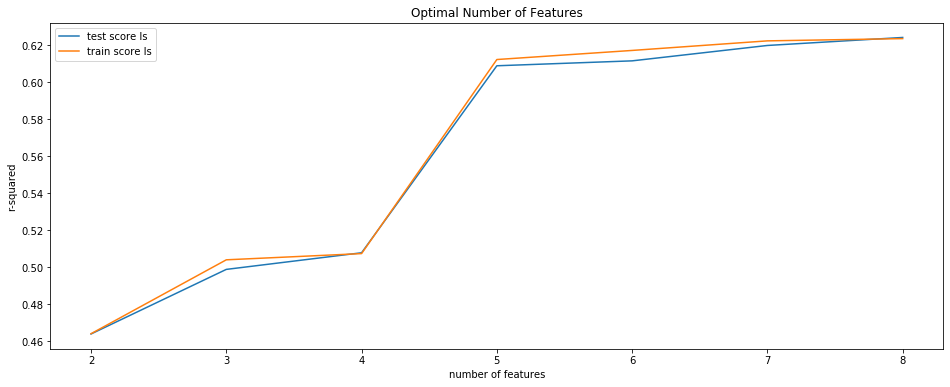

In [46]:
plt.figure(figsize=(16,6))
plt.plot(clf_results["param_n_features_to_select"], clf_results["mean_test_score"])
plt.plot(clf_results["param_n_features_to_select"], clf_results["mean_train_score"])
plt.xlabel('number of features')
#plt.ylim(0,1)
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score ls', 'train score ls'], loc='upper left')

In [47]:
df2 = pd.DataFrame(y_pred_clf_r)
df2['real'] = y_train
df2['correct'] = df2[0] == df2['real']
df2.groupby('correct').count()

,0,real
correct,,
False,1135,1135
True,1876,1876


## SVM
Penalization Parameters = 0.5, 1, 10000

In [ ]:
#--------------------SVM-----------------------------

# specify range of hyperparameters
C = [0.1, 10000]

df_svm = pd.DataFrame(columns = ['C', 'features','mean_test_score', 'rank_test_score', 'mean_train_score']) 

for i in C:
    # specify model
    svm = SVC(kernel='linear', C=i)
    svm.fit(x_train, y_train)
    rfe_svm = RFE(svm)  

    # set up GridSearchCV()
    model_svm = GridSearchCV(estimator = rfe_svm, 
                            param_grid = hyper_params, 
                            scoring= acc, 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    results_svm = model_svm.fit(x_train, y_train)
    svm_results = pd.DataFrame(results_svm.cv_results_)
    for index, row in svm_results.iterrows():
        df_svm = df_svm.append({'C' : i, 'features' : svm_results.loc[index, 'param_n_features_to_select'], 
                              'mean_test_score' : svm_results.loc[index, 'mean_test_score'], 
                              'rank_test_score':svm_results.loc[index, 'rank_test_score'],
                             'mean_train_score':svm_results.loc[index, 'mean_train_score']},  
                    ignore_index = True)

df_svm

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 276.3min finished


Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


## Aggregate all the best models in one Dataset

In [48]:
data = {'Features':  [2, 3,4,5,6, 7, 8]}

df = pd.DataFrame(data)
df['ls_mean_test_score'] = ls_results['mean_test_score']

In [49]:
df_rd_max = df_rd.groupby('features').mean_test_score.agg(['min']).reset_index()
df['rd_mean_test_score'] = df_rd_max['min']

In [50]:
df_clf_max = df_clf.groupby('features').mean_test_score.agg(['min']).reset_index()
df['clf_mean_test_score'] = df_clf_max['min']

In [51]:
df

,Features,ls_mean_test_score,rd_mean_test_score,clf_mean_test_score
0,2,0.426775,0.381605,0.463968
1,3,0.427105,0.383931,0.498499
2,4,0.421454,0.383931,0.506142
3,5,0.443710,0.416468,0.608756
4,6,0.450353,0.419462,0.611079
5,7,0.484893,0.437730,0.619386
6,8,0.481568,0.437730,0.624037


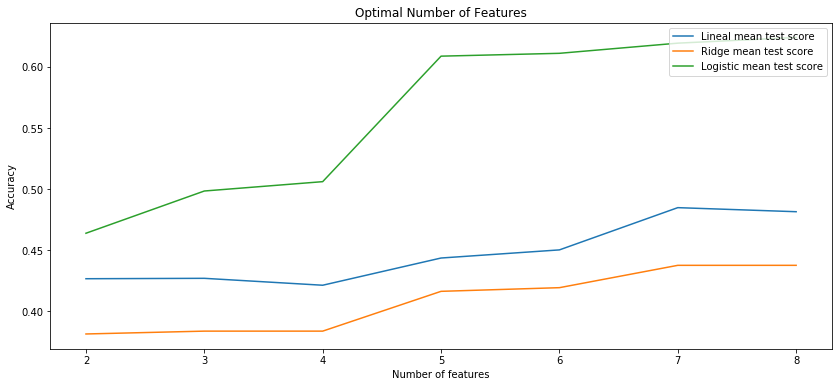

In [52]:
plt.figure(figsize=(14,6))

plt.plot(df["Features"], df["ls_mean_test_score"])
plt.plot(df["Features"], df["rd_mean_test_score"])
plt.plot(df["Features"], df["clf_mean_test_score"])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("Optimal Number of Features")
plt.legend(['Lineal mean test score', 'Ridge mean test score', 'Logistic mean test score'], loc='upper right')